In [1]:
__author__ = 'Erwin Chen'
%matplotlib inline
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.table import Table, join, Column
import numpy as np
from numpy.random import rand
import scipy.stats as stats
from scipy.sparse import lil_matrix
import scipy.spatial.distance as distance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from sklearn import mixture, preprocessing
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.cluster import v_measure_score, homogeneity_completeness_v_measure
import cPickle as pickle

In [2]:
def jaccard(a,b):
    """
    Calculate Jaccard distance between two arrays
    Parameters:
    -----------
    a: an array
    b: an array
    """
    A = np.array(a, dtype='int')
    B = np.array(b, dtype='int')
    A = A[np.where(A > -1)[0]]
    B = B[np.where(B > -1)[0]]
    union = np.union1d(A,B)
    intersection = np.intersect1d(A,B)
    return 1.0 - len(intersection)*1.0 / len(union)

In [3]:
def get_friends(data, num_element, n_chem, n_rv):
    """
    Get neartest neighbors in both chemical and radial velocity spaces for every star.
    Parameters:
    -----------
    data: a matrix that contains chemical abundances and radial velocities
    num_element: number of elements in the matrix
    n_chem: number of nearest neighbors in chemical space 
    n_rv: number of nearest neighbors in radial velocity space
    """
    data = np.array(data)
    index_chem = np.arange(0, num_element, 1)
    nbrs_chem = NearestNeighbors(n_neighbors=n_chem, algorithm='ball_tree', metric='manhattan').fit(data[:,index_chem])
    distances_chem, indices_chem = nbrs_chem.kneighbors(data[:,index_chem])
    index_rv = np.arange(num_element, len(data[0]), 1)
    rv_data = np.copy(data[:,index_rv])
    if len(rv_data[0]) < 2:
        rv_data = rv_data.reshape(-1, 1)
    nbrs_rv = NearestNeighbors(n_neighbors=n_rv, algorithm='ball_tree').fit(rv_data)
    distances_rv, indices_rv = nbrs_rv.kneighbors(rv_data)
    indices = []
    for n in range(len(indices_chem)):
        indices.append(np.intersect1d(indices_chem[n], indices_rv[n]))
    indices = np.array(indices)
    return indices

In [4]:
def iterator_dist(indices):
    """
    An iterator that calculates ans stores the Jaccard distance between every two stars
    Parameters:
    -----------
    indices: a list of indices of neighbors for every star
    """
    for n in range(len(indices)):
        for m in range(n+1, len(indices)):
            dist = jaccard(indices[n], indices[m])
            if dist < 1:
                yield (n, m, dist)

In [5]:
## load example dataset
element_names = np.array(['V_H', 'TI_H', 'CA_H','FE_H', 'K_H', 'MN_H', 'NI_H', 'SI_H', 'S_H'])
ap_table = pickle.load(open("example_dataset.p","rb")) 

In [6]:
ap_table

APOGEE_ID,VHELIO_AVG,V_H,TI_H,CA_H,FE_H,K_H,MN_H,NI_H,SI_H,S_H,SNR,cluster_name,label
str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,int64
2M00001242+5524391,-114.505996704,-0.0720647822626,0.0871973214217,-0.0004729417385,0.122795179264,0.08554547514,0.267394583712,0.153576455233,0.374741572947,0.276756974477,131.035003662,background,-1
2M00002868+5550240,-32.2458000183,0.12724201615,-0.152801301455,-0.177058682796,0.0228092089134,-0.0999016167266,0.139978427826,-0.00788235196693,0.233230792539,0.177730461872,184.229003906,background,-1
2M00014233+6345133,-74.6035995483,-0.535414631704,-0.307416844504,-0.25492156533,-0.174877175082,-0.512895863564,-0.199500034252,-0.188820315537,0.123634908983,-0.0515463890765,220.477005005,background,-1
2M00040006+0056115,10.8994998932,-0.0029170591069,-0.12740202017,-0.175551048689,-0.0873698993866,-0.205115425449,0.0152562296969,-0.129366143136,0.00105390056836,-0.141287121574,203.458999634,background,-1
2M00051282+7509188,-10.5131998062,-0.418715885662,-0.0284257252191,-0.0717451574103,-0.0399795341542,-0.210540694044,0.0188699085619,-0.0888822158834,0.024734618595,0.0869166934141,141.149002075,background,-1
2M00051617+7358285,-93.2919006348,-0.566560866096,-0.0946429901111,-0.225041425383,-0.230484820109,-0.26019738179,-0.410168912308,-0.283181802496,-0.0314674576093,-0.263603329854,218.548995972,background,-1
2M00052225-0004062,-7.71602010727,0.0686989826524,-0.240039192064,-0.273612440045,-0.306343683472,-0.599750855749,-0.271973806787,-0.495864645017,-0.221354334378,-0.0617944848777,114.239997864,background,-1
2M00063084+7317122,-96.1143035889,-0.282781173017,0.19746288434,0.00266294021528,0.128587418198,-0.0515173538198,0.22686908412,0.154131599329,0.249321152866,0.164563339269,153.738006592,background,-1
2M00063707+6947305,-75.4756011963,-0.0430846617826,-0.546121416596,-0.417726224886,-0.261782352909,-0.327251145915,-0.205496355965,-0.326564160678,-0.0150595703565,-0.0672015397707,90.3468017578,background,-1


In [7]:
## Compile a matrix that contains chemical abundances and radial velocity
Fe_index = np.where(element_names == 'FE_H')[0][0]
chem = [ap_table[element]-ap_table['FE_H'] for element in element_names]
chem[Fe_index] = ap_table['FE_H']
chem.append(ap_table['VHELIO_AVG'])
chem_RV = np.array(chem).T
chem = np.delete(chem_RV,-1,1)
print chem.shape
print chem_RV.shape

(2055, 9)
(2055, 10)


In [8]:
%%time 
## Get the indices of nearest neighbors in chemical and radial velocity space for every star
indices = get_friends(chem_RV, 9, 150, 50)

CPU times: user 271 ms, sys: 5 ms, total: 276 ms
Wall time: 277 ms


In [9]:
## find min_samples for DBSCAN
lengths = np.array([len(indices[n]) for n in range(len(indices))])
H, edges = np.histogram(lengths)
print "Number of Stars/ Threshold"
for n in range(len(H)):
    print H[n], edges[n+1]

Number of Stars/ Threshold
937 5.7
878 10.4
96 15.1
31 19.8
19 24.5
16 29.2
12 33.9
21 38.6
22 43.3
23 48.0


In [10]:
## check if known members have sufficient number of neighbors
c_name = "M13"
members = np.where(ap_table['cluster_name'] == c_name)[0]
print lengths[members]

[41 36 47 42 38 30 44 41 37 40 36 41 41  1 39 34 41 30 25 35 38 36 47 33 42
 35 33 38 40 37 44 39 44 42 37 41 36 47 46 48 40 41 43 38 39 44 46 47 44 48
 44 32 46 42 42 48 47 39 35 45 48 35 36 41 45 35 45 27 33 27 44]


In [11]:
## Select stars with more than N_cut number of neighbors
N_cut = 1
non_noise = np.where(lengths > N_cut)[0]
print "%i stars has more than %i neighbors"%(len(non_noise), N_cut)

2005 stars has more than 1 neighbors


In [12]:
%%time

## Get the distance matrix
S = lil_matrix((len(non_noise), len(non_noise)))
for (n, m, dist) in iterator_dist(indices[non_noise]):
    S[n,m] = dist
    S[m,n] = dist

CPU times: user 1min 30s, sys: 8 ms, total: 1min 30s
Wall time: 1min 30s


In [13]:
## find eps for DBSCAN
core = np.where(lengths[non_noise] > 11)[0]
S_core = S[core][:,core]
dist = np.array([])
for n in range(len(core)):
    row = S_core[n].todense()
    d = np.asarray(row[row > 0])[0]
    dist = np.append(dist, np.sort(d)[:11])
dist = np.sort(dist)
x = np.arange(len(dist))

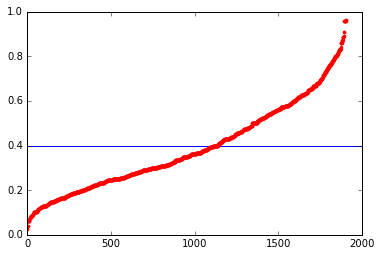

In [14]:
plt.axhline(y=0.4, xmin=0, xmax=1)
plt.plot(x, dist, "r.")
plt.show()

In [15]:
%%time 

## DBSCAN SNN
db = DBSCAN(eps=0.4, min_samples=11, metric='precomputed', n_jobs=-1).fit(S, lengths[non_noise])
labels = db.labels_
n_clumps = np.amax(labels) + 1
true_labels = ap_table["label"][non_noise]
print "%i clusters found"%n_clumps
print "#Categorized as Member/ Ratio of Member: ", 
print len(np.where(labels != -1)[0]), "/", len(np.where(labels != -1)[0])*1.0/len(labels)

2 clusters found
#Categorized as Member/ Ratio of Member:  98 / 0.0488778054863
CPU times: user 20 ms, sys: 1 ms, total: 21 ms
Wall time: 20.4 ms


70 members recovered:
81 stars in this group


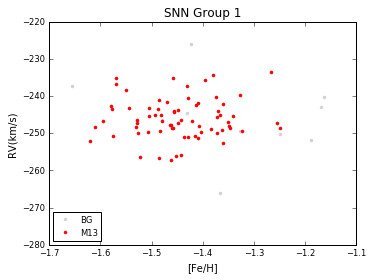

In [16]:
xlab = "[Fe/H]"
ylab = "RV(km/s)"
X = ap_table['FE_H']
Y = ap_table['VHELIO_AVG']
for n in range(max(labels)+1):
    group = non_noise[np.where(labels == n)[0]]
    group_members = np.intersect1d(members, group)
    if len(group_members) > 0:
        print "%i members recovered:"%len(group_members)
        print "%i stars in this group"%len(group)
        fig = plt.figure(figsize=(5.5, 4))
        plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
        plt.plot(X[group_members], Y[group_members], ".", c='r', label="M13")
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.xticks(fontsize="small")
        plt.yticks(fontsize="small")
        plt.legend(loc=3, fontsize="small", numpoints=1)
        plt.title("SNN Group %i"%n)
        plt.show()

In [17]:
## KMeans Chemical Tagging
k_num = 3
random_state = 123
kmeans = KMeans(n_clusters=k_num, random_state=random_state, max_iter=200)
kmeans.fit_predict(chem)
km_labels = kmeans.labels_

70 members recovered:
500 stars in this group


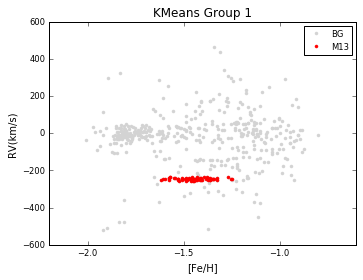

1 members recovered:
678 stars in this group


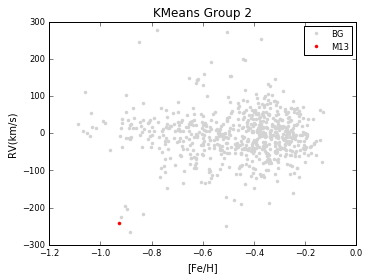

In [18]:
xlab = "[Fe/H]"
ylab = "RV(km/s)"
X = ap_table['FE_H']
Y = ap_table['VHELIO_AVG']
for n in range(max(km_labels)+1):
    group = np.where(km_labels == n)[0]
    group_members = np.intersect1d(members, group)
    if len(group_members) > 0:
        print "%i members recovered:"%len(group_members)
        print "%i stars in this group"%len(group)
        fig = plt.figure(figsize=(5.5, 4))
        plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
        plt.plot(X[group_members], Y[group_members], ".", c='r', label="M13")
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.xticks(fontsize="small")
        plt.yticks(fontsize="small")
        plt.legend(loc=0, fontsize="small", numpoints=1)
        plt.title("KMeans Group %i"%n)
        plt.show()

In [19]:
## find eps for DBSCAN
nbrs = NearestNeighbors(n_neighbors=25, algorithm='ball_tree', metric='manhattan').fit(chem)
dist, indices = nbrs.kneighbors(chem)
dist = dist.flatten()
dist = dist[dist > 0]
dist = np.sort(dist)
x = np.arange(len(dist))

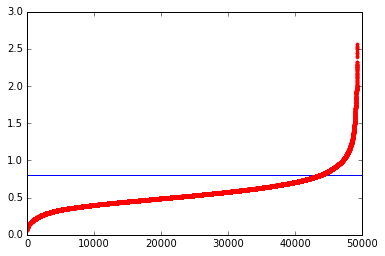

In [20]:
plt.axhline(y=0.8, xmin=0, xmax=1)
plt.plot(x, dist, "r.")
plt.show()

In [21]:
## DBSCAN Chemical Tagging
db = DBSCAN(eps=0.45, min_samples=25, metric='manhattan', n_jobs=-1).fit(chem)
db_labels = db.labels_
print "%i groups found"%len(db_labels)

2055 groups found


57 members recovered:
172 stars in this group


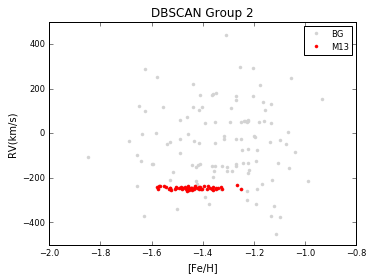

In [22]:
xlab = "[Fe/H]"
ylab = "RV(km/s)"
X = ap_table['FE_H']
Y = ap_table['VHELIO_AVG']
for n in range(max(db_labels)+1):
    group = np.where(db_labels == n)[0]
    group_members = np.intersect1d(members, group)
    if len(group_members) > 0:
        print "%i members recovered:"%len(group_members)
        print "%i stars in this group"%len(group)
        fig = plt.figure(figsize=(5.5, 4))
        plt.plot(X[group], Y[group], ".", c="lightgrey", label="BG")
        plt.plot(X[group_members], Y[group_members], ".", c='r', label="M13")
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.xticks(fontsize="small")
        plt.yticks(fontsize="small")
        plt.legend(loc=0, fontsize="small", numpoints=1)
        plt.title("DBSCAN Group %i"%n)
        plt.show()